## <strong> SafeML - A tool for safety monitoring of ML components </strong>

### <em>StaDRe and StaDRo </em>: Reliability and Robustness Estimation of ML-based Forecasting using Statistical Distance Measures

As technology moves toward higher degrees of automation in cars, the use of AI, and specifically Machine Learning (ML), becomes more common. The assurance of the safety of such systems is a huge problem, as they add new sources of risk into the system. SafeML is one of various risk-reduction approaches that has been proposed in:
<br>https://www.springerprofessional.de/en/safeml-safety-monitoring-of-machine-learning-classifiers-through/18346420</br>

SafeML method addresses safety and security during operation of ML systems by actively monitoring the distance between design-time trained context and runtime context using Empirical Cumulative Distribution Function (ECDF)- based distance measures.
The entire code of SafML is avaiable at: https://github.com/ISorokos/SafeML

Ensuring dependability of ML systems is crucial, particularly when deployed in safety-critical applications as the decisions based
on model predictions can result in hazardous situations. For ML-based systems to be used in safety-critical systems, certain qualities of
ML solutions such as reliability, fairness, robustness, transparency, and security are important.  

This work focuses on two quailities that are desired from ML solutions: <em>Reliability</em> and <em>Robustness</em> and uses SafeML for time series data. With this objective, distance measures based on ECDF proposed in SafeML are investigated for measuring Statistical-Distance Dissimilarity (SDD) across time series. We then present two novel metrics: SDD-based Reliability Estimate (StaDRe) and SDD-based Robustness (StaDRo).

Link to pre-print version of this work: http://arxiv.org/abs/2206.11116




<em>This notebook provides a runtime example for the computation of StaDRe. The example considered here is financial-critical i.e. company's stock closing price.</em>

The rest of the notebook is organized as follows:

<ol>
    <li>Data Acquisition, pre-processing, visualization and preparation. </li>
    <li>Application of DTW-based K-Means clustering. </li>
    <li>Model training (if built from scratch) or Loading a trained model </li>
    <li>Evaluation of model's performance at runtime</li>
    <li>Computation of StaDRe in stages.</li>
    <li>StaDRe estimates.</li>
    <li>StaDRe vs. Performance behaviour</li>
</ol>

### Import necessray libraries

In [1]:
import os
import sys

nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import math
import matplotlib.dates as mdates

from core.time_series_clustering import KmeansClustering
from core.data_preparation import DataPreparation
from core.helpers import compute_difference
from core.curve_fit import stadre_performance_visualization

### Check the computing platform

In [4]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')

print("PyTorch using device :", DEVICE)

PyTorch using device : cpu


### Data Acquisition

First step in building a prediction module, is to get the historical data. Currently there exists number of apis that we can utilise to get the dataset. In this notebook we explore use of the following libraries getting Stock history.
<ul>
    <li> NSEpy </li>
    <li> Yahoo Finance </li>
</ul>


The closing price of a stock is recorded every day on weekdays. On weekends, no data is collected.

In [5]:
DATAFOLDERPATH = os.path.join(os.path.dirname(os.getcwd()), 'Data')

Using NSEpy - NSEpy is a library for National Stock Exchange of India.

In [6]:
from nsepy import get_history
from datetime import date

# Provide start and end dates for acquiring historical data
start_date = date(2010,1,1)
end_date = date.today()

# Get historical data for specific company by choosing specific symbol, in this case Reliance data.
data = get_history(symbol="RELIANCE", start=start_date, end=end_date)

# Now convert this data to Kaggle format so that we can use it in training and testing. The Kaggle accepts data in following format.
kaggle_filepath = os.path.join(DATAFOLDERPATH, 'Kaggle_sample.csv')
sample = pd.read_csv(kaggle_filepath)
print("The kaggle data should be in following format.")
sample.head()


The kaggle data should be in following format.


,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,82.45,82.55,80.81,82.06,11715200,IBM
1,2006-01-04,82.20,82.50,81.33,81.95,9840600,IBM
2,2006-01-05,81.40,82.90,81.00,82.50,7213500,IBM
3,2006-01-06,83.95,85.03,83.41,84.95,8197400,IBM
4,2006-01-09,84.10,84.25,83.38,83.73,6858200,IBM


In [7]:
# Select the required columns for the new dataset and rename the columns to suit to Kaggle format.
new_dataset = data[['Open','High', 'Low', 'Close', 'Volume', 'Symbol']]
new_dataset.columns = ['Open','High', 'Low', 'Close', 'Volume', 'Name']

export_name = data["Symbol"][0]+ '_' + str(start_date) + str(end_date) + '.csv'
full_save_path = os.path.join(DATAFOLDERPATH, export_name)
new_dataset.to_csv(full_save_path)

Using Yahoo Finance

Yahoo Finance allows to download historical data from the following link - https://finance.yahoo.com/. Follow the below given steps:
<ul>
    <li> Click on the above link. </li>
    <li> Search for the company for which the data is to be acquired by typing the symbol or company name in the search bar. </li>
    <li> Click on Historical Data and select required start and end dates </li>
    <li> Finally, click on Download </li>
</ul>

The data provided by Yahoo Finace is already a match to Kaggle format except for the missing Name column. However, as we are only working with Closing price of the company's stock data over a certain period of time, we could use the dataset file acquired from Yahoo Finance as it is without converting it explicitly to Kaggle Format.

In [8]:
# Exceute the following block of code for converting data acquired from Yahoo Finance into Kaggle format (Optional).
symbol = 'Google'
filename = 'YahooFinance_Google_Example.csv'
filepath = os.path.join(DATAFOLDERPATH, filename)
data = pd.read_csv(filepath, header=0)

# Drop additional column Adj Close and add Name column
data.drop('Adj Close', axis=1, inplace=True)
data['Name'] = symbol

data.head()

,Date,Open,High,Low,Close,Volume,Name
0,2021-06-01,2422.000000,2437.970947,2404.879883,2429.810059,958300,Google
1,2021-06-02,2435.310059,2442.000000,2404.199951,2421.280029,857900,Google
2,2021-06-03,2395.020020,2409.745117,2382.830078,2404.610107,917300,Google
3,2021-06-04,2422.520020,2453.858887,2417.770020,2451.760010,1297400,Google
4,2021-06-07,2451.320068,2468.000000,2441.072998,2466.090088,1192500,Google


In [9]:
# Read the dataset file from the Data directory, which is already acquired. 
# We use the RELIANCE company dataset until 30-08-2021 that was acquired at the time of implementation of the project in order to reproduce the presented results.
# However, any other datasets with different start and end dates can be used.

filepath = os.path.join(DATAFOLDERPATH, 'RELIANCE_2010-01-012021-08-30.csv')
data = pd.read_csv(filepath, usecols=[0,4], names=['date', 'close'], header=0)
data = data.sort_values('date')
data['date'] = pd.to_datetime(data['date'])
data.head()

,date,close
0,2010-01-04,1075.50
1,2010-01-05,1070.70
2,2010-01-06,1088.00
3,2010-01-07,1106.05
4,2010-01-08,1103.15


In [10]:
# Check for the length of data and for any missing values. 
print("Length of the dataset:", len(data))
print("Are there any missing values:", data.isnull().values.any())

Length of the dataset: 2895
Are there any missing values: False


In [11]:
# Remove the entries with NaN and cross-check if these are additional data added on weekends or some weekday data is missing.
# Execute only if there are missing values.
data.dropna(inplace=True)
data.reset_index(drop=True, inplace=True)

### Visualize the univariate time series read from the .csv file
#### (Example: RELIANCE company's stock closing price)

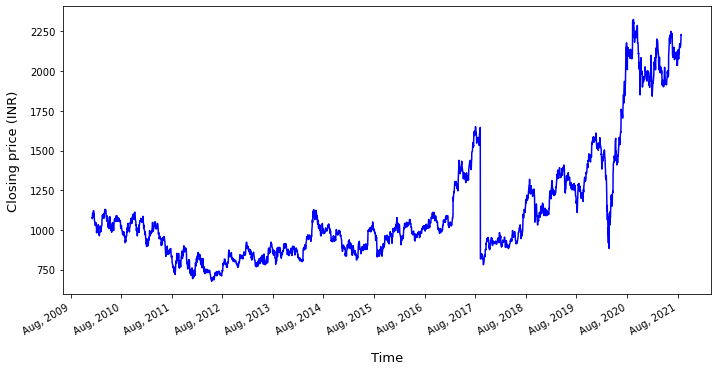

In [12]:
#Creates just a figure and only one subplot
fig, ax = plt.subplots(figsize=(9,5))
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
ax.plot(data['date'], data['close'], c='b')
ax.set_xlabel('Time', fontsize=13, labelpad=15)
ax.set_ylabel('Closing price (INR)', fontsize=13,  labelpad=10)
half_year_locator = mdates.MonthLocator(interval=12)
year_month_formatter = mdates.DateFormatter("%Y-%m")
ax.xaxis.set_major_locator(half_year_locator)
month_year_formatter = mdates.DateFormatter('%b, %Y')
ax.xaxis.set_major_formatter(month_year_formatter)
fig.autofmt_xdate()
plt.show()

The stock price data for Reliance is collected from 01-01-2010 (start date) to 31-08-2021 (end date), resulting in a 2895-day time period. Looking at the data, it is visible that there is an increasing trend in the time series beginning around July 2020, and stock prices are rising year after year.

### Setup training and test phases

To forecast future values using forecasting methods, the entire dataset is split into training and test sets (hold-out). The training set is used to determine forecasting model parameters by fitting data to it, whereas the test set is used to assess the accuracy of this trained model. All datasets utilized in this work are split into two parts: 80% training and 20% testing. The closing price data is normalized between -1 and 1 for training and evaluating forecasting models. This work primarily focuses on univariate time series with <em>one-step </em> ahead prediction (i.e. forecast horizon = 1). The <em>window size</em> or <em>lookback period</em> are tuned differently for every use case. The example in this notebook considers a <em>window size of 20</em>.

In [13]:
# Define the length of training data, here 80% of the entire data is considered.
train_len = 0.8*len(data)

# Define window size or the lookback period to be used while forecasting time series.
window_size = 20

# Initialize data preparation with default test fraction and window size
dataset = DataPreparation()

# Divide the data intro training and test set with default values as 80% training data and 20% 
train_set, test_set = dataset.splitData(data['close'].values)

# Length of actual test set
actual_test_len = len(test_set) - window_size

# Define feature range for normalization of the data.
scaler = MinMaxScaler(feature_range=(-1, 1))

# Formulate time series into supervised learning problem using sliding window approach
scaler, x_train, x_test, y_train_lstm, y_test_lstm = dataset.prepare_data_with_normalization(data['close'].values, scaler)

x_train.shape =  (2296, 20, 1)
y_train.shape =  (2296, 1)
x_test.shape =  (559, 20, 1)
y_test.shape =  (559, 1)


### Apply DTW-based K-Means clustering

In [14]:
# Choose number of clusters to group training data into several groups with similar pattern.
num_clusters = 7

In [15]:
# Apply K-means clustering by setting number of clusters as required and the compute clusters on training data.
kmeans = KmeansClustering(num_clusters)
kmeans.compute_clusters(x_train)

DBA k-means


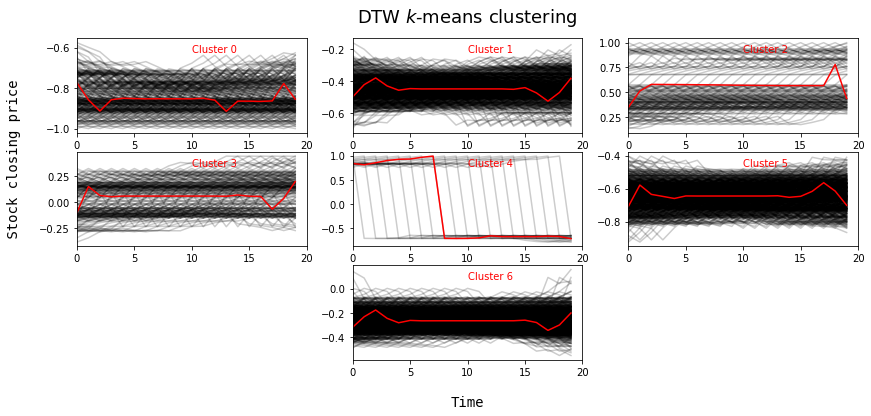

In [16]:
# Visualize the result of clustering
kmeans.visualize_clustering_results()

In [17]:
# Creats an array of cluster centres in the original scale.
clusters = []
for i in range(num_clusters):
    clusters.append(scaler.inverse_transform(kmeans.cluster_centers_[i].flatten().reshape(-1,1)))

### Build and Train a forecasting model from scratch

For forecasting, any of the available deep learning architectures can be used. This work primarily focuses on LSTM and GRU models that models can be built and trained from scratch. For Reliance, the LSTM architecture was designed with two hidden layers and a hidden dimension of 32. The model was trained over 100 epochs using the Adam optimizer with mean squared error as the loss function. A learning rate of 0.01 was found to be optimal. 

In [18]:
# input_dim = 1
# hidden_dim = 32
# num_layers = 2
# output_dim = 1
# num_epochs = 100

# model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
# criterion = torch.nn.MSELoss(reduction='mean')
# optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

# hist = np.zeros(num_epochs)
# lstm = []

# for t in range(num_epochs):
#     y_train_pred = model(x_train)

#     loss = criterion(y_train_pred, y_train_lstm)
#     hist[t] = loss.item()

#     optimiser.zero_grad()
#     loss.backward()
#     optimiser.step()  


### Save the trained model

In [19]:
# torch.save(model, 'lstm_rel.pt')

### (or) Load an already trained model and setup the mode to evaluation

Once an optimal model is trained and saved, the model can be loaded in future for further steps. After loading the model, set the model to evaluation mode.

In [20]:
full_model_path = os.path.join(os.path.dirname(os.getcwd()), 'trained_models', 'lstm_rel.pt')
model = torch.load(full_model_path)
model.eval()

LSTM(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)

### Predict on the hold-out dataset

Forecast accuracy must be evaluated in order to determine the quality of forecasts predicted by the model. Forecast errors must be calculated in order to determine forecast accuracy. In this work, forecasting errors are computed using several error metrics
<ul>
    <li>Root Mean Square Error (RMSE)</li>
    <li>Mean Absolute Percentage Error (MAPE)</li>    
</ul>

In this work, we also employ the coefficient of determination, often known as R2 or R-squared, which is a commonly used regression performance measure. 

In [21]:
# make predictions
y_test_pred = model(x_test)

# invert predictions
y_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test_lstm.detach().numpy())

# calculate root mean squared error
test_error = mean_absolute_percentage_error(y_test[:,0], y_pred[:,0])
accuracy_reg = r2_score(y_test[:, 0], y_pred[:, 0])
rmse = math.sqrt(mean_squared_error(y_test[:,0], y_pred[:,0]))
print('Test Score')
print('MAPE: %.2f' % (test_error))
print(f'R-Squared: {accuracy_reg}')
print('RMSE: ', rmse)

preds = y_test_pred[:, 0]
gt = y_test[:, 0]

Test Score
MAPE: 0.05
R-Squared: 0.8750267436432391
RMSE:  129.89433806944783


#### Predict the cluster for forecast data

In [22]:
# Prepare forecasts for clustering predictions
preds = y_test_pred.detach().numpy()
preds = preds[:, 0]
loop = len(preds) - window_size + 1 
forecasts = []

for i in range(loop):        
    window = preds[i:i+window_size]
    forecasts.append(window)  

forecasts = np.asarray(forecasts).reshape(-1, window_size, 1)

In [23]:
# Prepare ground truth of hold-out set for performance evaluation
gt = y_test_lstm.detach().numpy()
gt = gt[:, 0]
loop = len(gt) - window_size + 1 
test_gt = []

for i in range(loop):        
    window = gt[i:i+window_size]
    test_gt.append(window)  

test_gt = np.asarray(test_gt).reshape(-1, window_size, 1)

In [24]:
# Compare the shapes of forcasts and ground truth prepared for clustering
test_gt.shape, forecasts.shape

((540, 20, 1), (540, 20, 1))

In [25]:
# Predict cluster for every forecast instance.
res = kmeans.predict(forecasts)

## StaDRe

In order to compute StaDRe, we first define a reference time series Origin $O$. This provides a frame of reference for assessing dissimilarities between data instances. Then we compute SDD between each cluster centre and the Origin.
We then compute the SDD between assigned cluster centre and data instance for which reliability is to be computed. Finally rate of change of SDD is estimated.

Next step is to compute Mean Squared Performance Error for each cluster using nearest neighbors of given data instance. The steps are described later in detail.

Furthermore, we evaluate the performance of these forecasting windows to study their behaviour with StaDRe estimates. Following this, curve-fitting is applied to illustrate and study this behaviour.

Finally, StaDRe for a data instance $X^*$ is computed using the equation:

$$StaDRe(X^*) = \dfrac{2 - \dfrac{1}{m} \displaystyle \sum_{i=1}^{m} \epsilon_{i}^{2} - \dfrac{f(c, X^*)}{f(c, O)}}{2}$$

#### Find distances between each cluster centroid and a reference time series

In [26]:
# Create a reference time series with all 0s and same size as cluster centre.
ref_ts = np.zeros(window_size)
ref_ts

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

In [27]:
# Compute Wasserstein Distance between each clsuter centre and reference time series.
clusters_wd_dist = []
for i in range(num_clusters):
    wd = kmeans.compute_wasserstein_distance(clusters[i].flatten(), ref_ts)
    clusters_wd_dist.append(wd)

In [28]:
clusters_wd_dist

[747.1121584011,
 944.0910577753757,
 1430.6199491063933,
 1188.0235283265793,
 1137.978650128355,
 850.4023392879934,
 1034.0564824139203]

In [29]:
# Randomly select any forecasts for each reliability estimate is required to be estimated
# np.random.seed(4)
# indices = np.random.choice(range(0, len(forecasts), 1), 15)

#Fix these values of indices to reacreate results presented in the paper
indices = [213, 413, 279, 452, 167, 508, 504,  34, 404, 375, 415, 474,  32,
         5, 233]

In [30]:
# Compute SDD between cluster centre and each of selected data (forecasting) instance
t = indices
df = kmeans.ecdf_between_cluster_and_data(t, scaler, forecasts, res, clusters_wd_dist)
df

,Test point,Test point mean,Assigned cluster,WD origin,Anderson_Darling_dist,CVM_dist,DTS_dist,Kolmogorov_Smirnov_dist,Kuiper_dist,Wasserstein_dist
0,213,0.363980,2,1430.619949,3.089701,7.90,39.874778,0.45,0.80,102.896992
1,413,1.406145,2,1430.619949,7.045834,19.75,137.609253,1.00,1.00,412.235154
2,279,1.498227,2,1430.619949,7.045834,19.75,151.317210,1.00,1.00,457.004746
3,452,1.417780,2,1430.619949,7.045834,19.75,138.596622,1.00,1.00,417.973863
4,167,0.560667,2,1430.619949,2.466734,6.65,8.507434,0.50,0.75,18.996446
5,508,1.617764,2,1430.619949,7.045834,19.75,169.137784,1.00,1.00,515.395408
6,504,1.639234,2,1430.619949,7.045834,19.75,171.746956,1.00,1.00,525.851389
7,34,0.103495,3,1188.023528,2.601362,6.65,15.580126,0.45,0.75,38.816165
8,404,1.367670,2,1430.619949,7.045834,19.75,132.184635,1.00,1.00,393.298069
9,375,1.404408,2,1430.619949,7.045834,19.75,135.607323,1.00,1.00,411.395744


### Compute rate of change of SDD

In [31]:
df['WD ratio'] = df['Wasserstein_dist'] / df['WD origin']
df

,Test point,Test point mean,Assigned cluster,WD origin,Anderson_Darling_dist,CVM_dist,DTS_dist,Kolmogorov_Smirnov_dist,Kuiper_dist,Wasserstein_dist,WD ratio
0,213,0.363980,2,1430.619949,3.089701,7.90,39.874778,0.45,0.80,102.896992,0.071925
1,413,1.406145,2,1430.619949,7.045834,19.75,137.609253,1.00,1.00,412.235154,0.288151
2,279,1.498227,2,1430.619949,7.045834,19.75,151.317210,1.00,1.00,457.004746,0.319445
3,452,1.417780,2,1430.619949,7.045834,19.75,138.596622,1.00,1.00,417.973863,0.292163
4,167,0.560667,2,1430.619949,2.466734,6.65,8.507434,0.50,0.75,18.996446,0.013278
5,508,1.617764,2,1430.619949,7.045834,19.75,169.137784,1.00,1.00,515.395408,0.360260
6,504,1.639234,2,1430.619949,7.045834,19.75,171.746956,1.00,1.00,525.851389,0.367569
7,34,0.103495,3,1188.023528,2.601362,6.65,15.580126,0.45,0.75,38.816165,0.032673
8,404,1.367670,2,1430.619949,7.045834,19.75,132.184635,1.00,1.00,393.298069,0.274914
9,375,1.404408,2,1430.619949,7.045834,19.75,135.607323,1.00,1.00,411.395744,0.287565


#### Find MSE of each data point using CONFINE method

In [32]:
cluster_size = []
for i in range(num_clusters):
    cluster_size.append(len(kmeans.data[kmeans.data_preds == i]))

for i, size in enumerate(cluster_size):
    print(f"cluster {i}- {size}")

cluster 0- 223
cluster 1- 511
cluster 2- 125
cluster 3- 163
cluster 4- 19
cluster 5- 620
cluster 6- 635


In [33]:
# Select value of m (number of nearest neighbors) equal to size of smallest cluster.
num_nearest_neighbors = min(cluster_size)
print("Number of nearest neighbors is:", num_nearest_neighbors)

Number of nearest neighbors is: 19


##### Get indices of the training points that have been assigned to respective cluster

In [34]:
cluster_members = {}
for i in range(num_clusters):
    cluster_members[i] = np.where(kmeans.labels_ == i)

### Compute performance error on nearest neighbours of test instance in the training set 

In order to compute MSE on nearest neighbours, following steps are implemented:
<ol>
    <li>Begin by computing the difference between actual values and predictions of training data.</li>
    <li>Square the difference values returned.</li>
    <li>Compute the mean squared error on nearest neighbors and normalize the value between 0 and 1.</li>
</ol>

In [35]:
y_train_pred = model(x_train)
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train_lstm.detach().numpy())

In [36]:
training_diff = compute_difference(y_train[:, 0], y_train_pred[:, 0])

##### Get training points (members) of each cluster 

In [37]:
cluster_errors = {}
for i in range(num_clusters):
    cluster_errors[i] = training_diff[cluster_members[i][0]]

In [38]:
# Set seed of random number generator
cluster_neighbors = {}
# Choose m neraest neighbors randomly 
for i in range(num_clusters):
    np.random.seed(21)
    cluster_neighbors[i] =  np.random.choice(cluster_errors[i], 19, replace=False)

In [39]:
# Find MSE of each cluster and normalize the values between 0 and 1.
scaler_mse = MinMaxScaler(feature_range=(0, 1))
clusters_mse = {}
for i in range(num_clusters):
    squared_error = np.array([n ** 2 for n in cluster_neighbors[i]])
    squared_error_norm = scaler_mse.fit_transform(squared_error.reshape(-1, 1))
    squared_error_norm = np.around(squared_error_norm, 4)
    mse = np.mean(squared_error_norm)
    clusters_mse[i] = np.round(mse, 4)

In [40]:
mse_all_data = []
for i in df['Assigned cluster']:
    mse_all_data.append(clusters_mse[i])

In [41]:
df['mse'] = mse_all_data
df

,Test point,Test point mean,Assigned cluster,WD origin,Anderson_Darling_dist,CVM_dist,DTS_dist,Kolmogorov_Smirnov_dist,Kuiper_dist,Wasserstein_dist,WD ratio,mse
0,213,0.363980,2,1430.619949,3.089701,7.90,39.874778,0.45,0.80,102.896992,0.071925,0.3188
1,413,1.406145,2,1430.619949,7.045834,19.75,137.609253,1.00,1.00,412.235154,0.288151,0.3188
2,279,1.498227,2,1430.619949,7.045834,19.75,151.317210,1.00,1.00,457.004746,0.319445,0.3188
3,452,1.417780,2,1430.619949,7.045834,19.75,138.596622,1.00,1.00,417.973863,0.292163,0.3188
4,167,0.560667,2,1430.619949,2.466734,6.65,8.507434,0.50,0.75,18.996446,0.013278,0.3188
5,508,1.617764,2,1430.619949,7.045834,19.75,169.137784,1.00,1.00,515.395408,0.360260,0.3188
6,504,1.639234,2,1430.619949,7.045834,19.75,171.746956,1.00,1.00,525.851389,0.367569,0.3188
7,34,0.103495,3,1188.023528,2.601362,6.65,15.580126,0.45,0.75,38.816165,0.032673,0.1425
8,404,1.367670,2,1430.619949,7.045834,19.75,132.184635,1.00,1.00,393.298069,0.274914,0.3188
9,375,1.404408,2,1430.619949,7.045834,19.75,135.607323,1.00,1.00,411.395744,0.287565,0.3188


### Evaluate performance of selected forecasting instances

In [42]:
rmse_errors = []
mape_errors = []
r2score = []
for i in t:
    
    forecast = scaler.inverse_transform(forecasts[i])
    gt = scaler.inverse_transform(test_gt[i])        
    rmse = math.sqrt(mean_squared_error(gt, forecast))
    rmse_errors.append(rmse)

    mape = mean_absolute_percentage_error(gt, forecast)
    mape_errors.append(mape*100)

    r2 = r2_score(gt, forecast)
    r2score.append(r2)

In [43]:
# Append the performance measured in RMSE, MAPE, R-Squared to the existing dataframe.
df = df.assign(**{'RMSE': rmse_errors, 'MAPE':mape_errors, 'R-Squared': r2score})
df 

,Test point,Test point mean,Assigned cluster,WD origin,Anderson_Darling_dist,CVM_dist,DTS_dist,Kolmogorov_Smirnov_dist,Kuiper_dist,Wasserstein_dist,WD ratio,mse,RMSE,MAPE,R-Squared
0,213,0.363980,2,1430.619949,3.089701,7.90,39.874778,0.45,0.80,102.896992,0.071925,0.3188,53.066142,3.212771,0.834247
1,413,1.406145,2,1430.619949,7.045834,19.75,137.609253,1.00,1.00,412.235154,0.288151,0.3188,136.688100,6.286176,-2.537312
2,279,1.498227,2,1430.619949,7.045834,19.75,151.317210,1.00,1.00,457.004746,0.319445,0.3188,186.379747,8.501302,-3.006229
3,452,1.417780,2,1430.619949,7.045834,19.75,138.596622,1.00,1.00,417.973863,0.292163,0.3188,124.105259,6.059451,-4.516971
4,167,0.560667,2,1430.619949,2.466734,6.65,8.507434,0.50,0.75,18.996446,0.013278,0.3188,32.222110,1.792289,0.207750
5,508,1.617764,2,1430.619949,7.045834,19.75,169.137784,1.00,1.00,515.395408,0.360260,0.3188,193.676296,8.851054,-11.092919
6,504,1.639234,2,1430.619949,7.045834,19.75,171.746956,1.00,1.00,525.851389,0.367569,0.3188,210.769628,9.506159,-12.758016
7,34,0.103495,3,1188.023528,2.601362,6.65,15.580126,0.45,0.75,38.816165,0.032673,0.1425,44.437801,2.745444,0.370022
8,404,1.367670,2,1430.619949,7.045834,19.75,132.184635,1.00,1.00,393.298069,0.274914,0.3188,135.140299,6.281461,-3.899670
9,375,1.404408,2,1430.619949,7.045834,19.75,135.607323,1.00,1.00,411.395744,0.287565,0.3188,132.306809,6.567965,-26.891225


### Compute StaDRe

In [44]:
df['StaDRe'] = (2 - df['mse'] - df['WD ratio'] ) / 2

In [45]:
df_Re = df[['Test point', 'Assigned cluster', 'RMSE', 'MAPE', 'R-Squared', 'WD origin', 'Wasserstein_dist', 'WD ratio', 'mse', 'StaDRe']]
df_Re

,Test point,Assigned cluster,RMSE,MAPE,R-Squared,WD origin,Wasserstein_dist,WD ratio,mse,StaDRe
0,213,2,53.066142,3.212771,0.834247,1430.619949,102.896992,0.071925,0.3188,0.804638
1,413,2,136.688100,6.286176,-2.537312,1430.619949,412.235154,0.288151,0.3188,0.696524
2,279,2,186.379747,8.501302,-3.006229,1430.619949,457.004746,0.319445,0.3188,0.680877
3,452,2,124.105259,6.059451,-4.516971,1430.619949,417.973863,0.292163,0.3188,0.694519
4,167,2,32.222110,1.792289,0.207750,1430.619949,18.996446,0.013278,0.3188,0.833961
5,508,2,193.676296,8.851054,-11.092919,1430.619949,515.395408,0.360260,0.3188,0.660470
6,504,2,210.769628,9.506159,-12.758016,1430.619949,525.851389,0.367569,0.3188,0.656816
7,34,3,44.437801,2.745444,0.370022,1188.023528,38.816165,0.032673,0.1425,0.912414
8,404,2,135.140299,6.281461,-3.899670,1430.619949,393.298069,0.274914,0.3188,0.703143
9,375,2,132.306809,6.567965,-26.891225,1430.619949,411.395744,0.287565,0.3188,0.696818


### Apply Curve fitting to StaDRe vs. Performance

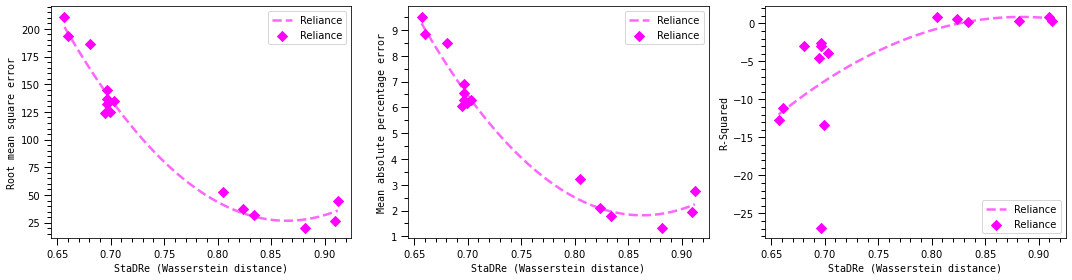

In [46]:
stadre_performance_visualization(df_Re['StaDRe'].values, df_Re['RMSE'].values, df_Re['MAPE'].values, df_Re['R-Squared'].values, label='Reliance')

The plots in the preceding figure are fitted using a second-degree curve. The graph clearly indicates increased performance with increasing reliability, StaDRE, validating the metric.

The current work implements the StaDRe measure to univariate time series; future work could include experimenting with multivariate time series for classification and regression problems, as well as time series with periodicity.

By giving each component a different weight and using it on a real-world dataset, it is possible to adjust how the StaDRe measure currently accounts for error rate of nearest neighbors and rate of change of SDD.